In [1]:
from preprocess_data import Custom_Dataset, ChannelMNISTDataset
from torch.utils.data import DataLoader
import torch
from model import BaseConvModel, ProtoModel, FinalLayer, WholeModel, exp_var_dict
from push_prototypes import push
import h5py
from receptive_field import compute_rf, output_to_input
import matplotlib.pyplot as plt
import numpy as np
import argparse
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.optim.lr_scheduler as lr_scheduler
from torchgeo_euro import EuroSAT, ScaleAndNormalize
from torchvision.transforms import v2 as transforms
import matplotlib
import pickle


In [ ]:
if torch.cuda.is_available():
    torch.set_default_device('cuda')
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    device = torch.device('cuda')
    print("GPU is set as the default device.")
else:
    print("CUDA is not available. CPU will be used as the default device.")
    device = 'cpu'


prototype_info = 'data/models/mjo_models/mjo_prototype_info_noise'
model_name = 'data/models/mjo_models/mjo_model_noise.pth'

GPU is set as the default device.


/users/anaray34/.local/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [3]:
exp_dataset = exp_var_dict['exp_dataset']
whole = WholeModel(exp_dataset, exp_var_dict['num_channels'])

with open(prototype_info, "rb") as fp:   
    prototype_info_list = pickle.load(fp)

whole.load_state_dict(torch.load(model_name))


<All keys matched successfully>

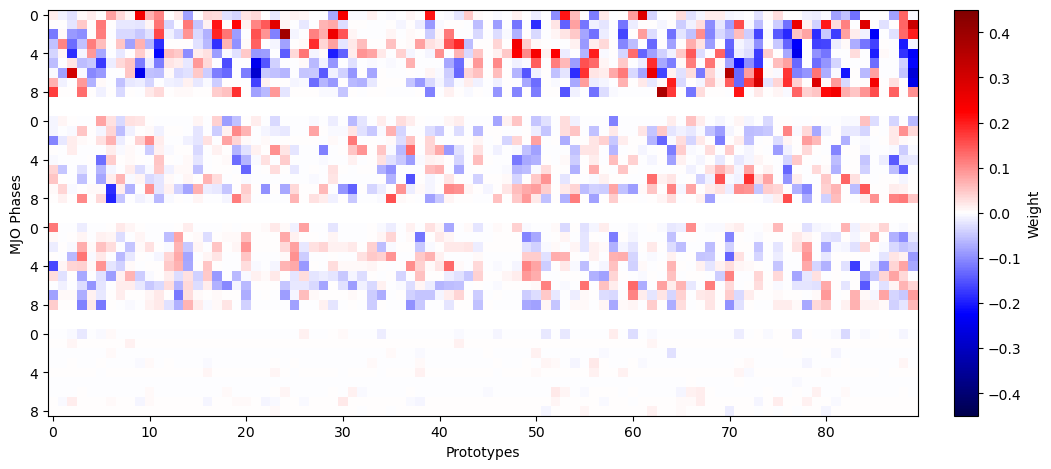

In [4]:

weights = whole.final_list[0].last_layer.weight.cpu().detach().numpy()  

data = weights
num_channels = 4
gap = 2  
blocks = np.hsplit(data, num_channels)

spaced_blocks = []
for i, b in enumerate(blocks):
    spaced_blocks.append(b)
    if i < num_channels - 1:
        spaced_blocks.append(np.full((gap, b.shape[1]), np.nan))

stacked_data = np.vstack(spaced_blocks)

norm = matplotlib.colors.TwoSlopeNorm(vmin=-0.45, vcenter=0, vmax=0.45)

cmap = plt.get_cmap("seismic").copy()
cmap.set_bad(color="white")

fig, ax = plt.subplots(figsize=(12, 24))
fig.subplots_adjust(right=0.85)

im = ax.imshow(stacked_data, cmap=cmap, aspect="equal", norm=norm)
ax_pos = ax.get_position()
cax = fig.add_axes([
    ax_pos.x1 + 0.03,  
    ax_pos.y0,        
    0.02,            
    ax_pos.height 
])

cbar = fig.colorbar(im, cax=cax)
cbar.set_label("Weight")

ticks = []
labels = []
rows_per_block = blocks[0].shape[0]
offset = 0
for _ in range(num_channels):
    ticks.extend([offset + 0, offset + 4, offset + 8])
    labels.extend([0, 4, 8])
    offset += rows_per_block + gap

ax.set_yticks(ticks)
ax.set_yticklabels(labels)

ax.set_xlabel("Prototypes")
ax.set_ylabel("MJO Phases")

#plt.savefig('mjo_figs/mjo_weights_noise2.pdf', format='pdf', bbox_inches='tight')

plt.show()
